## Retrieval Augmented Generation
In retrieval augmented generation (RAG), an LLM retrieves contextual documents from an external dataset as part of its execution. 

RAG (Retrieval-Augmented Generation) is an AI framework that combines the strengths of traditional information retrieval systems (such as databases) with the capabilities of generative large language models (LLMs)

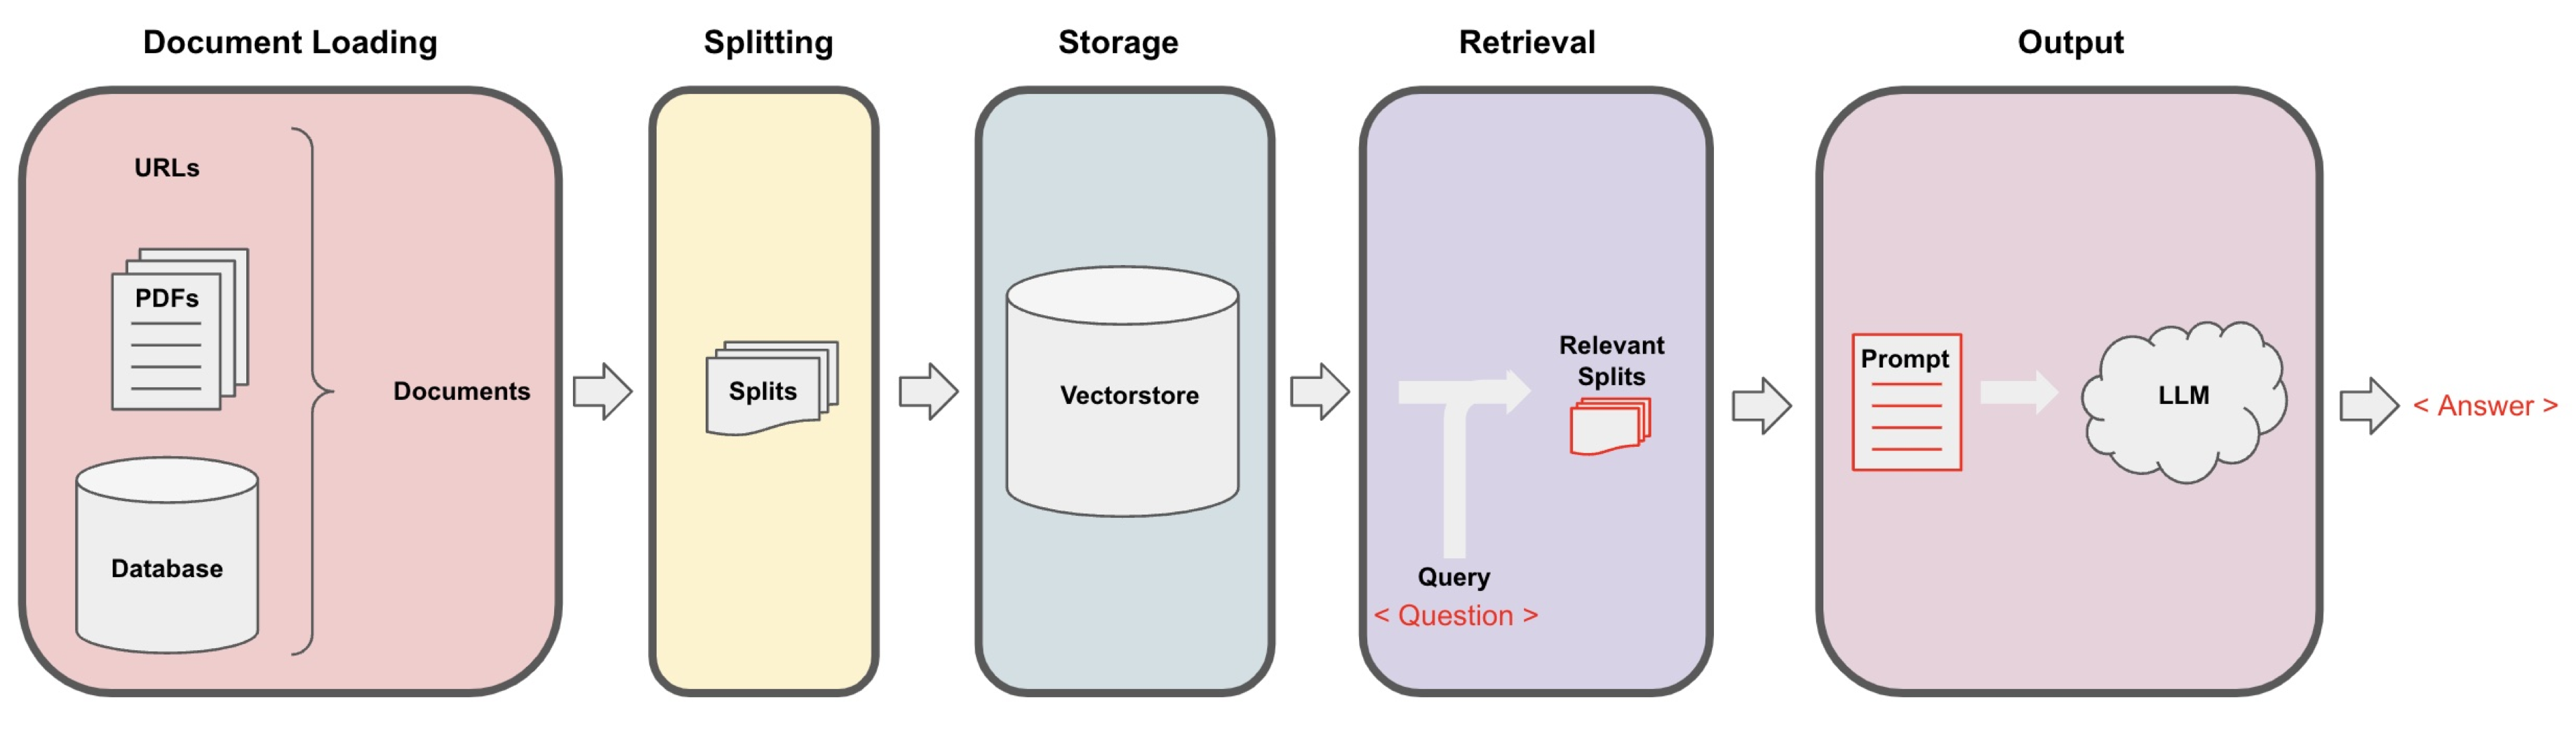

In [55]:
# Import the required libraries
import time
import os
import json
import uuid
from dotenv import dotenv_values
from openai import AzureOpenAI
import gradio as gr


#Cosmos DB imports
from azure.cosmos import CosmosClient
from azure.cosmos.partition_key import PartitionKey
from langchain_community.vectorstores.azure_cosmos_db_no_sql import (
    AzureCosmosDBNoSqlVectorSearch,
)
from langchain_openai import AzureOpenAIEmbeddings, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.chat_models import AzureChatOpenAI
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain_community.chat_message_histories import CosmosDBChatMessageHistory

import gradio as gr
import panel as pn
pn.extension()
import param

In [130]:
# Variables
# specify the name of the .env file name 
env_name = "nosql.env" # following example.env template change to your own .env file name
config = dotenv_values(env_name)

cosmos_conn = config['cosmos_connection_string']
cosmos_key = config['cosmos_key']
cosmos_database = config['cosmos_database_name']
cosmos_container = config['cosmos_container_name']

openai_endpoint = config['openai_endpoint']
openai_key = config['openai_key']
openai_api_version = config['openai_version']
openai_embeddings_deployment = config['openai_embeddings_deployment']
openai_embeddings_model = config['openai_embeddings_model']
openai_embeddings_dimensions = int(config['openai_embeddings_dimensions'])
openai_completions_deployment = config['openai_completions_deployment']

os.environ["OPENAI_API_KEY"] = ""

openai_embeddings = OpenAIEmbeddings(disallowed_special=())

azure_openai_embeddings = AzureOpenAIEmbeddings(
    azure_deployment = openai_embeddings_deployment,
    api_key= openai_key,
    azure_endpoint= openai_endpoint,
    model= openai_embeddings_model,
    dimensions= openai_embeddings_dimensions,
)

# Load

In [125]:
usr_dir_path = "/Users/aayushkataria/git/"
dir = usr_dir_path + "AzureDataRetrievalAugmentedGenerationSamples/Python/Pdf-Dataset/abstracts_pdf/"
docs = []
for file in os.listdir(dir):
    pdf_path = dir + file
    loader = PyPDFLoader(pdf_path)
    docs.extend(loader.load())
print(len(docs))

1292


# Split

In [126]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)
documents = text_splitter.split_documents(docs)

# Create the Azure Cosmos DB for NoSQL client

In [131]:
indexing_policy = {
    "indexingMode": "consistent",
    "includedPaths": [{"path": "/*"}],
    "excludedPaths": [{"path": '/"_etag"/?'}],
    "vectorIndexes": [{"path": "/embedding", "type": "quantizedFlat"}],
}

vector_embedding_policy = {
    "vectorEmbeddings": [
        {
            "path": "/embedding",
            "dataType": "float32",
            "distanceFunction": "cosine",
            "dimensions": 1536,
        }
    ]
}

partition_key = PartitionKey(path="/id")
cosmos_container_properties = {"partition_key": partition_key}

cosmos_client = CosmosClient(url=cosmos_conn, credential=cosmos_key)

database = cosmos_client.create_database_if_not_exists(cosmos_database)
print('Database with id \'{0}\' created'.format(cosmos_database))

container = database.create_container_if_not_exists(
    id=cosmos_container,
    partition_key=PartitionKey(path="/id"),
    offer_throughput=30000,
    indexing_policy=indexing_policy,
    vector_embedding_policy=vector_embedding_policy   
)
print('Container with id \'{0}\' created'.format(cosmos_container))

Database with id 'CVPR2019_db' created
Container with id 'abstracts' created


In [132]:
documents[0].page_content

'To mitigate the detection performance drop caused by domain shift, we aim to develop a novel few-shot adaptation approach that requires only a few target domain images with limited bounding box annotations. To this end, we first observe several significant challenges. First, the target domain data is highly insufficient, making most existing domain adaptation methods ineffective. Second, object detection involves simultaneous localization and classification, further complicating the model adaptation process. Third, the model suffers from over-adaptation (similar to overfitting when training with a few data example) and instability risk that may lead to degraded detection performance in the target domain. To address these challenges, we first introduce a pairing mechanism over source and target features to alleviate the issue of insufficient target domain samples. We then propose a bi-level module to adapt the source trained detector to the target domain: 1) the split pooling based ima

## Embeddings generation

In [122]:
# generate openai embeddings
def generate_embeddings_azure(text):    
    response = azure_openai_embeddings.embed_query(text)
    time.sleep(0.5) 
    return response

# generate openai embeddings
def generate_embeddings(text):    
    response = openai_embeddings.embed_query(text)
    time.sleep(0.5) 
    return response

## Insert documents in the container using CosmosDB APIs

In [123]:
# import uuid
# for i in range(0, len(documents)):
#     item = {
#         'id': str(uuid.uuid4()),  # Ensure 'id' is a string
#         'text': documents[i].page_content,
#         'embedding': generate_embeddings(documents[i].page_content),        
#     }
#     container.create_item(body=item)

## Create AzureCosmosDB NoSQL Vector Search

In [133]:
# If the documents already exist in the container
vector_store = AzureCosmosDBNoSqlVectorSearch(
    embedding=openai_embeddings,
    cosmos_client=cosmos_client,
    database_name=cosmos_database,
    container_name=cosmos_container,
    vector_embedding_policy=vector_embedding_policy,
    indexing_policy=indexing_policy,
    cosmos_database_properties={},
    cosmos_container_properties=cosmos_container_properties,
    create_container=False,
)


# Below lines can be used to create a vector store, and insert the documents.

# vector_store = AzureCosmosDBNoSqlVectorSearch.from_documents(
#     documents=documents,
#     embedding=azure_openai_embeddings,
#     cosmos_client=cosmos_client,
#     database_name=cosmos_database,
#     container_name=cosmos_container,
#     vector_embedding_policy=vector_embedding_policy,
#     indexing_policy=indexing_policy,
#     cosmos_database_properties={},
#     cosmos_container_properties=cosmos_container_properties,
#     create_container=False,
# )

## Basic Vector Search

In [137]:
# Perform a similarity search between the embedding of the query and the embeddings of the documents
query = "Explain computer vision to me"
results = vector_store.similarity_search(query)

print("Result:", results[0].page_content)

Result: Visual understanding goes well beyond object recognition. With one glance at an image, we can effortlessly imagine the world beyond the pixels: for instance, we can infer people's actions, goals, and mental states. While this task is easy for humans, it is tremendously difficult for today's vision systems, requiring higher-order cognition and commonsense reasoning about the world. We formalize this task as Visual Commonsense Reasoning. Given a challenging question about an image, a machine must answer correctly and then provide a rationale justifying its answer.  Next, we introduce a new dataset, VCR, consisting of 290k multiple choice QA problems derived from 110k movie scenes. The key recipe for generating non-trivial and high-quality problems at scale is Adversarial Matching, a new approach to transform rich annotations into multiple choice questions with minimal bias. Experimental results show that while humans find VCR easy (over 90% accuracy), state-of-the-art vision mode

## Vector Search with Similarity Score

In [144]:
query = "What is pattern recognition?"
results = vector_store.similarity_search_with_score(query)

print("Result:", results[0][0].page_content)
print("Score:", results[0][1])

Result: Visual object recognition under situations in which the direct line-of-sight is blocked, such as when it is occluded around the corner, is of practical importance in a wide range of applications. With coherent illumination, the light scattered from diffusive walls forms speckle patterns that contain information of the hidden object. It is possible to realize non-line-of-sight (NLOS) recognition with these speckle patterns. We introduce a novel approach based on speckle pattern recognition with deep neural network, which is simpler and more robust than other NLOS recognition methods. Simulations and experiments are performed to verify the feasibility and performance of this approach.
Score: 0.8130233499972038


## Vector Search with relevance scores

In [150]:
# Perform a similarity search between the embedding of the query and the embeddings of the documents
query = "Explain computer vision to me"
results = vector_store.max_marginal_relevance_search(query)

print("Result:", results[0].page_content)
print("Score:", results[0].metadata["SimilarityScore"])

Result: Visual understanding goes well beyond object recognition. With one glance at an image, we can effortlessly imagine the world beyond the pixels: for instance, we can infer people's actions, goals, and mental states. While this task is easy for humans, it is tremendously difficult for today's vision systems, requiring higher-order cognition and commonsense reasoning about the world. We formalize this task as Visual Commonsense Reasoning. Given a challenging question about an image, a machine must answer correctly and then provide a rationale justifying its answer.  Next, we introduce a new dataset, VCR, consisting of 290k multiple choice QA problems derived from 110k movie scenes. The key recipe for generating non-trivial and high-quality problems at scale is Adversarial Matching, a new approach to transform rich annotations into multiple choice questions with minimal bias. Experimental results show that while humans find VCR easy (over 90% accuracy), state-of-the-art vision mode

## Interactive ChatBot using Gradio

In [151]:
prompt_template = """
You are an upbeat AI assistant who is excited to help answer questions. 
You can use this context

{context},

or this chat history

{chat_history},

to answer this question. 

Question: {question}
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
"""
chatbot_prompt = PromptTemplate(
    template = prompt_template, input_variables = ["context", "question", "chat_history"])

In [152]:
def prepare_chain():
    llm = AzureChatOpenAI(
            azure_endpoint = openai_endpoint,
            api_key = openai_key,
            api_version = openai_api_version,
            azure_deployment = openai_completions_deployment, 
            cache = False,
            n = 1)

    retriever = vector_store.as_retriever(search_type = "similarity",search_kwargs = {"k": 5, 'score_threshold': 0.2})

    sem_qa = ConversationalRetrievalChain.from_llm(
            llm = llm,
            chain_type = "stuff",
            retriever = retriever,
            return_source_documents = True,
            combine_docs_chain_kwargs = {"prompt": chatbot_prompt}
    )

    return retriever, llm, sem_qa

In [153]:
chatbot_chain_retriever, chatbot_chain_llm, chatbot_chain = prepare_chain()



# Clearing Semantic Cache before every testing cycle
# database.delete_container("abstracts_history")

cosmos_message_history = CosmosDBChatMessageHistory(
    session_id = "test_session",
    cosmos_endpoint = cosmos_conn,
    cosmos_database = cosmos_database,
    cosmos_container = "abstracts_history",
    credential = cosmos_key,
    user_id = "ak")
cosmos_message_history.prepare_cosmos()

conversational_memory = ConversationBufferMemory(
    chat_memory=cosmos_message_history,
    memory_key='chat_history',
    return_messages=True)

# Load history locally. Grab last 
hist = []
with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")

    def user(user_message, chat_history):
        # Get response from QA chain
        response = chatbot_chain.invoke({"question": user_message, "chat_history":conversational_memory.buffer_as_messages[-6:]},temperature=0.2)
        # Append user message and response to chat history
        hist.append(["User: "+user_message, "Chatbot: "+response['answer']])
        cosmos_message_history.add_user_message(user_message)
        cosmos_message_history.add_ai_message(response['answer'])
        return gr.update(value=""), hist
    

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False)
    clear.click(lambda: None, None, chatbot, queue=False)

In [ ]:
demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
demo.close()

### Some example queries for the chatbot.
1. Explain pattern recognition to me.
2. What are the advantages of using computer vision.
3. Give me some different techniques for pattern recognition.